In [358]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter


## Data Cleaning and Exploratory Data Analysis

In [395]:
# read the csv
df = pd.read_csv('train.csv')
df.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/2004,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/2014,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/2012,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/2009,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [396]:
# Have a overal view of the dataset
# look at the shape of the df
print(df.shape)
# look at the types of columns
print('\n', df.dtypes)



(3000, 23)

 id                         int64
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object


### Handling missing data

In [397]:
# look at what columns contain missing values and how many
print(df.isna().sum()[df.isna().sum() !=0])

belongs_to_collection    2396
genres                      7
homepage                 2054
overview                    8
poster_path                 1
production_companies      156
production_countries       55
runtime                     2
spoken_languages           20
tagline                   597
Keywords                  276
cast                       13
crew                       16
dtype: int64


A nil value in "belongs_to_collection" column means the movie is not part of any collection

In [398]:
# replacing the empty values in "belongs_to_collection" to zero
df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else x)

The Homepage columne is basically irrelevant to our project

In [399]:
# removing the irrelevant column (homepage)
df = df.drop('homepage',axis=1)


In [400]:
# removing rows with empty values
df = df.dropna()

In [407]:
# The shape of the cleaned dataframe
df.shape

(2229, 22)

Rows where budget equals to zero is considered missing values. So we also remove those rows

In [408]:
df_cleaned = df[df['budget']!=0]

After cleaning the dataset, we ended up with a dataset with nearly 1,800 samples

In [409]:
df_cleaned.shape

(1796, 22)

## Transforming the JSON objects in the CSV to a proper python object

In [410]:
# Convert string columns to proper python object
string_cols = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']


def convert(df, cols=string_cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: x if x==0 
                                else ast.literal_eval(x))
    return df

df_treated = convert(df_cleaned)


/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/1350278253.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: x if x==0


### Whether the movie belongs to a collection or not

In [411]:
# For belongs_to_collection col, actually missing value represents Nil

df_treated['collection_or_not'] = df_treated['belongs_to_collection'].apply(lambda x: 0 if x==0 else 1)

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/2497242737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['collection_or_not'] = df_treated['belongs_to_collection'].apply(lambda x: 0 if x==0 else 1)


0    74.888641
1    25.111359
Name: collection_or_not, dtype: float64


Text(0.5, 1.0, 'Proportion of movies that are in a collection')

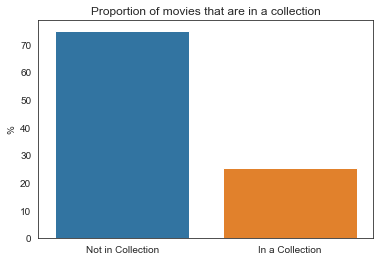

In [412]:
# % of our training movies belongs to a collection
collection_proportion = df_treated['collection_or_not'].value_counts(normalize=True)*100
print(collection_proportion)
sns.barplot(x=collection_proportion.index,
            y=collection_proportion.values)
plt.xticks([0,1],['Not in Collection','In a Collection'])
plt.ylabel('%')
plt.title('Proportion of movies that are in a collection')


Create a new columne with the name of the Collection that the movie belongs to

In [414]:
df_treated['collection_name'] = df_treated['belongs_to_collection'].apply(lambda x: 0 if x==0 else x[0]['name'])

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/2771291709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['collection_name'] = df_treated['belongs_to_collection'].apply(lambda x: 0 if x==0 else x[0]['name'])


### How many kinds of genres are there?

In [417]:
# take a quick look at the col
df_treated['genres'][:5]

0                        [{'id': 35, 'name': 'Comedy'}]
1     [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                         [{'id': 18, 'name': 'Drama'}]
9     [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...
10                        [{'id': 18, 'name': 'Drama'}]
Name: genres, dtype: object

We can see that some movies belong to only 1 genre while some belongs to multiple genres.

Lets see what is the maximum number of genres a movie can be in

3    599
2    532
1    282
4    278
5     87
6     15
7      3
Name: genres, dtype: int64


Text(0.5, 1.0, 'Distribution of movie genres')

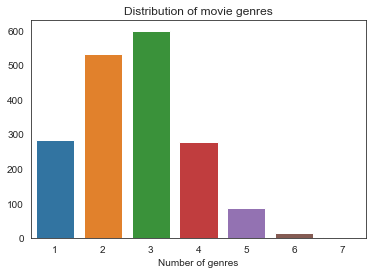

In [418]:
num_genres = df_treated['genres'].apply(lambda x: len(x)).value_counts()
print(num_genres)
sns.barplot(x=num_genres.index,
            y=num_genres.values)
plt.xlabel('Number of genres')
plt.title('Distribution of movie genres')

What are the unique genres?

In [419]:
genre_list = []

for i, row in df_treated.iterrows():
    for genres in row['genres']:
        genre_list.append(genres['name'])
    
genre_set = set(genre_list)
genre_set

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western'}

In [420]:
# Creating a genre_name column for easy classification
def genre(col):
    gen_list = []
    for i in col:
        gen_list.append(i['name'])
    return gen_list

df_treated['genres_name'] = df_treated['genres'].apply(lambda x: genre(x))

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/1137042182.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['genres_name'] = df_treated['genres'].apply(lambda x: genre(x))


In [421]:
# Creating a column for each genre
for i in list(genre_set):
    df_treated['genre_'+str(i)]=df_treated['genres_name'].apply(lambda x: 1 if i in x else 0)


/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/2488100743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['genre_'+str(i)]=df_treated['genres_name'].apply(lambda x: 1 if i in x else 0)


### Exploring the popularity score column

In [422]:
# look at the descriptive statistics of the column
df_treated.popularity.describe()

count    1796.000000
mean       10.513582
std        13.168966
min         0.079287
25%         6.385064
50%         8.998728
75%        12.165393
max       287.253654
Name: popularity, dtype: float64

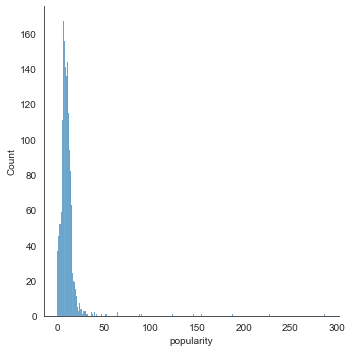

In [423]:
sns.displot(df_treated.popularity)

### Exploring the production companies

We can see that there are movies which are produced by only 1 company, but there are also movies that are produced by more than one companies. Lets find out:

2     468
1     391
3     381
4     224
5     136
6      88
7      44
8      32
9      18
10      5
11      5
16      1
12      1
14      1
17      1
Name: production_companies, dtype: int64


Text(0.5, 1.0, 'Distribution of number of production companies')

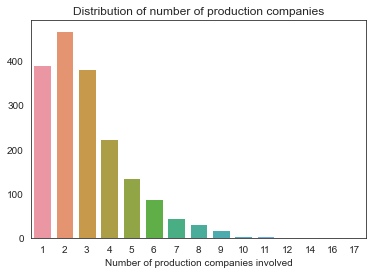

In [424]:
num_prod_companies = df_treated['production_companies'].apply(lambda x: len(x)).value_counts()
print(num_prod_companies)
sns.barplot(x=num_prod_companies.index,
            y=num_prod_companies.values)
plt.xlabel('Number of production companies involved')
plt.title('Distribution of number of production companies')

In [425]:
producer_list = []

for i, row in df_treated.iterrows():
    for producer in row['production_companies']:
        producer_list.append(producer['name'])
    
producer_set = set(producer_list)
producer_set

producer_list = list(producer_set)
print("There are {} unique production companies in total".format(len(producer_list)))

There are 2414 unique production companies in total


Lets just focus on the major production companies:

In [426]:
# Creating a prod_name column first
def prod(col):
    prod_list = []
    for i in col:
        prod_list.append(i['name'])
    return prod_list

df_treated['prod_company_name'] = df_treated['production_companies'].apply(lambda x: prod(x))

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/516817319.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['prod_company_name'] = df_treated['production_companies'].apply(lambda x: prod(x))


In [427]:
# Find out the top 15 production companies that produced the most movies
total = []
for i,row in df_treated.iterrows():
    for x in row['prod_company_name']:
        total.append(x)
    
Counter(total).most_common(15)

[('Warner Bros.', 157),
 ('Universal Pictures', 144),
 ('Paramount Pictures', 124),
 ('Twentieth Century Fox Film Corporation', 110),
 ('Columbia Pictures', 79),
 ('New Line Cinema', 62),
 ('Metro-Goldwyn-Mayer (MGM)', 56),
 ('Walt Disney Pictures', 53),
 ('Columbia Pictures Corporation', 47),
 ('Relativity Media', 43),
 ('Touchstone Pictures', 41),
 ('TriStar Pictures', 38),
 ('Village Roadshow Pictures', 36),
 ('United Artists', 34),
 ('Miramax Films', 31)]

### Exploring the production countries

1    1317
2     346
3      82
4      40
5      11
Name: production_countries, dtype: int64


Text(0.5, 1.0, 'Distribution of number of production countries')

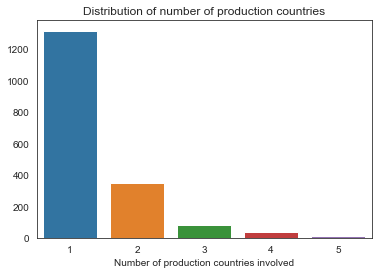

In [428]:
num_prod_countries = df_treated['production_countries'].apply(lambda x: len(x)).value_counts()
print(num_prod_countries)
sns.barplot(x=num_prod_countries.index,
            y=num_prod_countries.values)
plt.xlabel('Number of production countries involved')
plt.title('Distribution of number of production countries')

In [429]:
country_list = []

for i, row in df_treated.iterrows():
    for country in row['production_countries']:
        country_list.append(country['name'])
    
country_set = set(country_list)
country_set

country_list = list(country_set)
print("There are {} unique production countries in total".format(len(country_list)))

There are 59 unique production countries in total


In [430]:
# Creating a country_name column first
def country(col):
    country_list = []
    for i in col:
        country_list.append(i['name'])
    return country_list

df_treated['prod_country_name'] = df_treated['production_countries'].apply(lambda x: country(x))

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/1613388719.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['prod_country_name'] = df_treated['production_countries'].apply(lambda x: country(x))


In [431]:
# Find out the top 10 production countries that produced the most movies
total_country = []
for i,row in df_treated.iterrows():
    for x in row['prod_country_name']:
        total_country.append(x)
    
Counter(total_country).most_common(15)

[('United States of America', 1594),
 ('United Kingdom', 234),
 ('Germany', 111),
 ('France', 104),
 ('Canada', 85),
 ('Australia', 41),
 ('Italy', 28),
 ('Japan', 26),
 ('Spain', 20),
 ('China', 19),
 ('India', 17),
 ('Hong Kong', 16),
 ('Czech Republic', 12),
 ('Ireland', 11),
 ('New Zealand', 11)]

### Exploring the Release Date

In [432]:
df_treated['release_date'] = pd.to_datetime(df_treated['release_date'])

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/3667356631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['release_date'] = pd.to_datetime(df_treated['release_date'])


In [433]:
df_treated['release_date'][:10]

0    2015-02-20
1    2004-08-06
2    2014-10-10
9    2003-04-16
10   1976-11-21
12   1999-09-15
13   2005-03-04
14   2002-06-20
15   2010-10-06
16   2005-08-04
Name: release_date, dtype: datetime64[ns]

### Exploring the spoken language

1    1224
2     346
3     142
4      52
5      20
6       5
7       5
8       1
9       1
Name: spoken_languages, dtype: int64


Text(0.5, 1.0, 'Distribution of number of language')

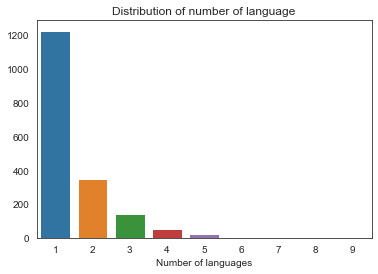

In [434]:
num_lang = df_treated['spoken_languages'].apply(lambda x: len(x)).value_counts()
print(num_lang)
sns.barplot(x=num_lang.index,
            y=num_lang.values)
plt.xlabel('Number of languages')
plt.title('Distribution of number of language')

In [435]:
lang_list = []

for i, row in df_treated.iterrows():
    for lang in row['spoken_languages']:
        lang_list.append(lang['name'])
    
lang_set = set(lang_list)
lang_set

lang_list = list(lang_set)
print("There are {} unique languages in total".format(len(lang_list)))

There are 52 unique languages in total


In [436]:
# Creating a lang_name column first
def lang(col):
    lang_list = []
    for i in col:
        lang_list.append(i['name'])
    return lang_list

df_treated['lang_name'] = df_treated['spoken_languages'].apply(lambda x: lang(x))

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/3528797662.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['lang_name'] = df_treated['spoken_languages'].apply(lambda x: lang(x))


In [437]:
# Find out the top 10 common languages in movie:
total_lang = []
for i,row in df_treated.iterrows():
    for x in row['lang_name']:
        total_lang.append(x)
    
Counter(total_lang).most_common(15)

[('English', 1722),
 ('Español', 170),
 ('Français', 165),
 ('Deutsch', 98),
 ('Pусский', 80),
 ('Italiano', 78),
 ('日本語', 51),
 ('普通话', 38),
 ('Português', 30),
 ('العربية', 30),
 ('', 28),
 ('Latin', 22),
 ('한국어/조선말', 22),
 ('ภาษาไทย', 16),
 ('广州话 / 廣州話', 15)]

### Exploring status

In [438]:
df_treated.status.value_counts()

Released    1796
Name: status, dtype: int64

### Exploring keywords

In [439]:
# Creating a keywords_list column first
def keywords(col):
    kw_list = []
    for i in col:
        kw_list.append(i['name'])
    return kw_list

df_treated['keywords_list'] = df_treated['Keywords'].apply(lambda x: keywords(x))

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/1004707473.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['keywords_list'] = df_treated['Keywords'].apply(lambda x: keywords(x))


In [440]:
# Find out the top 10 common keywords in movie:
total_kws = []
for i,row in df_treated.iterrows():
    for x in row['keywords_list']:
        total_kws.append(x)
    
Counter(total_kws).most_common(15)

[('duringcreditsstinger', 108),
 ('murder', 100),
 ('based on novel', 89),
 ('woman director', 86),
 ('independent film', 79),
 ('violence', 69),
 ('dystopia', 69),
 ('aftercreditsstinger', 65),
 ('revenge', 57),
 ('sequel', 49),
 ('sport', 49),
 ('friendship', 47),
 ('police', 47),
 ('suspense', 46),
 ('sex', 46)]

### Exploring Cast

In [441]:
# Creating a cast_list column first
def cast(col):
    cast_list = []
    for i in col:
        cast_list.append(i['name'])
    return cast_list

df_treated['cast_list'] = df_treated['cast'].apply(lambda x: cast(x))

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/2991859394.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['cast_list'] = df_treated['cast'].apply(lambda x: cast(x))


In [442]:
# Find out the top 10 common actors/actresses in movie:
total_cast = []
for i,row in df_treated.iterrows():
    for x in row['cast_list']:
        total_cast.append(x)
    
Counter(total_cast).most_common(15)

[('Samuel L. Jackson', 24),
 ('Morgan Freeman', 23),
 ('Bruce McGill', 22),
 ('Robert De Niro', 22),
 ('Bruce Willis', 21),
 ('Jason Statham', 20),
 ('George Clooney', 20),
 ('Ed Harris', 20),
 ('Sigourney Weaver', 20),
 ('Nicolas Cage', 20),
 ('Liam Neeson', 20),
 ('J.K. Simmons', 19),
 ('Sylvester Stallone', 18),
 ('Forest Whitaker', 18),
 ('Willem Dafoe', 18)]

### Exploring crew

In [443]:
job = []
for i in df_treated.crew[0]:
    job.append(i['job'])

In [444]:
job

['First Assistant Director',
 'Director',
 'Writer',
 'Characters',
 'Producer',
 'Associate Producer',
 'Executive Producer',
 'Executive Producer',
 'Original Music Composer',
 'Director of Photography',
 'Editor',
 'Casting',
 'Production Design',
 'Executive Producer',
 'Script Supervisor',
 'Production Coordinator',
 'Costume Design',
 'Set Decoration',
 'Hair Department Head',
 'Makeup Department Head',
 'Art Direction',
 'Production Supervisor',
 'Sound Re-Recording Mixer',
 'Sound Re-Recording Mixer',
 'Dialogue Editor',
 'Production Sound Mixer',
 'Sound Effects Editor',
 'Stunt Coordinator',
 'Camera Operator',
 'Still Photographer',
 'Rigging Gaffer',
 'Gaffer',
 'Music Supervisor',
 'Music Editor',
 'Music Editor',
 'Costume Supervisor',
 'Steadicam Operator',
 'First Assistant Camera',
 'Supervising Sound Editor',
 'Additional Writing',
 'Hairstylist',
 'Makeup Artist',
 'Makeup Artist',
 'Makeup Artist',
 'Makeup Artist',
 'Hairstylist',
 'First Assistant Director',
 'Gre

In [445]:
# Create a column for Director of the movie:

def director(row):
    for i in row:
        if i['job']=='Director':
            return i['name']
    

df_treated['director'] = df_treated['crew'].apply(lambda x: director(x))

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/3216981786.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['director'] = df_treated['crew'].apply(lambda x: director(x))


In [446]:
# Create a column for Writer of the movie:

def Writer(row):
    for i in row:
        if i['job']=='Writer':
            return i['name']
    

df_treated['Writer'] = df_treated['crew'].apply(lambda x: Writer(x))

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/2286192982.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['Writer'] = df_treated['crew'].apply(lambda x: Writer(x))


In [447]:
# Create a column for Executive Producer of the movie:

def EP(row):
    EP_list = []
    for i in row:
        if i['job']=='Executive Producer':
            EP_list.append(i['name'])
    return EP_list
    

df_treated['Executive Producer'] = df_treated['crew'].apply(lambda x: EP(x))

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/3357920941.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['Executive Producer'] = df_treated['crew'].apply(lambda x: EP(x))


In [448]:
df_treated['Executive Producer'].apply(lambda x: len(x)).value_counts()

0     827
1     334
2     222
3     147
4     128
5      58
6      30
7      20
8      13
9       6
10      5
11      2
15      1
18      1
13      1
12      1
Name: Executive Producer, dtype: int64

In [453]:
# Reseting the index 
df_treated.reset_index(inplace=True)

In [454]:
df_treated.to_csv('train_cleaned.csv')

=======

In [455]:
df_test1 = df_treated
df_test1.head()

,index,id,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,overview,popularity,...,genre_Family,genre_Action,prod_company_name,prod_country_name,lang_name,keywords_list,cast_list,director,Writer,Executive Producer
0,0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],[English],"[time travel, sequel, hot tub, duringcreditsst...","[Rob Corddry, Craig Robinson, Clark Duke, Adam...",Steve Pink,Josh Heald,"[Rob Corddry, Ben Ormand, Matt Moore]"
1,1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,1,0,[Walt Disney Pictures],[United States of America],[English],"[coronation, duty, marriage, falling in love]","[Anne Hathaway, Julie Andrews, H√©ctor Elizond...",Garry Marshall,None,[Ellen H. Schwartz]
2,2,3,0,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],[English],"[jazz, obsession, conservatory, music teacher,...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...",Damien Chazelle,None,"[Jason Reitman, Gary Michael Walters, Jeanette..."
3,9,10,0,6000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",tt0310281,en,A Mighty Wind,"In ""A Mighty Wind"", director Christopher Guest...",4.672036,...,0,0,[Castle Rock Entertainment],[United States of America],[English],"[mockumentary, folk singer]","[Bob Balaban, Christopher Guest, John Michael ...",Christopher Guest,Christopher Guest,[]
4,10,11,"[{'id': 1575, 'name': 'Rocky Collection', 'pos...",1000000,"[{'id': 18, 'name': 'Drama'}]",tt0075148,en,Rocky,"When world heavyweight boxing champion, Apollo...",14.774066,...,0,0,[United Artists],[United States of America],[English],"[underdog, philadelphia, transporter, italo-am...","[Sylvester Stallone, Talia Shire, Burt Young, ...",John G. Avildsen,None,[Gene Kirkwood]


In [456]:
#Creating a column for each country 

for i in list(country_set):
     df_test1['prod_country_'+str(i)]=df_test1['prod_country_name'].apply(lambda x: 1 if i in x else 0)

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/2126262625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1['prod_country_'+str(i)]=df_test1['prod_country_name'].apply(lambda x: 1 if i in x else 0)


In [457]:
list(df_test1.columns)

['index',
 'id',
 'belongs_to_collection',
 'budget',
 'genres',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'Keywords',
 'cast',
 'crew',
 'revenue',
 'collection_or_not',
 'collection_name',
 'genres_name',
 'genre_Science Fiction',
 'genre_Thriller',
 'genre_Foreign',
 'genre_Music',
 'genre_Horror',
 'genre_Romance',
 'genre_Drama',
 'genre_Mystery',
 'genre_Documentary',
 'genre_TV Movie',
 'genre_Fantasy',
 'genre_History',
 'genre_Adventure',
 'genre_Western',
 'genre_Crime',
 'genre_War',
 'genre_Animation',
 'genre_Comedy',
 'genre_Family',
 'genre_Action',
 'prod_company_name',
 'prod_country_name',
 'lang_name',
 'keywords_list',
 'cast_list',
 'director',
 'Writer',
 'Executive Producer',
 'prod_country_Czech Republic',
 'prod_country_Greece',
 'prod_country_Norway',
 'prod_country_France',

In [458]:
#Creating a column for each langg 

for i in list(set(total_lang)):
     df_test1['lang_'+str(i)]=df_test1['lang_name'].apply(lambda x: 1 if i in x else 0)
     #print(i)

/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/2111728307.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1['lang_'+str(i)]=df_test1['lang_name'].apply(lambda x: 1 if i in x else 0)
/var/folders/k2/0zwyn2913cvf5k4bldh_v2540000gn/T/ipykernel_76936/2111728307.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test1['lang_'+str(i)]=df_test1['lang_name'].apply(lambda x: 1 if i in x else 0)


In [459]:
import collections

type(total)

counts = Counter(total)

# Iterate over the dictionary and print each element followed by its count
for key, value in counts.items():
    print(key, "->", value)

Paramount Pictures -> 124
United Artists -> 34
Metro-Goldwyn-Mayer (MGM) -> 56
Walt Disney Pictures -> 53
Bold Films -> 4
Blumhouse Productions -> 17
Right of Way Films -> 2
Castle Rock Entertainment -> 17
DreamWorks SKG -> 27
Jinks/Cohen Company -> 1
Double Feature Films -> 7
Jersey Films -> 5
Nina Saxon Film Design -> 2
Cruise/Wagner Productions -> 5
Amblin Entertainment -> 17
Twentieth Century Fox Film Corporation -> 110
Blue Tulip Productions -> 2
Ronald Shusett/Gary Goldman -> 1
Digital Image Associates -> 1
Hypnopolis -> 1
Craven-Maddalena Films -> 3
BenderSpink -> 5
UK Film Council -> 8
Prescience -> 2
Aegis Film Fund -> 2
Kaleidoscope Films -> 1
Current Entertainment -> 3
TF1 Films Production -> 8
Canal+ -> 24
TPS Star -> 2
EuropaCorp -> 9
Sea Side Films Florida Inc. -> 1
New Line Cinema -> 62
Irwin Allen Productions -> 1
Prelude Pictures -> 2
Saltire Entertainment -> 1
Jason Productions -> 1
Jean Doumanian Productions -> 1
Sweetland Films -> 1
Magnolia Films -> 1
Jasmine Produ